In [39]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Open the H5 file
h5_file = h5py.File('../Data/SMAP_L3_SM_P_E_20250401_R19240_001.h5', 'r')

# List all groups and datasets in the file
def print_structure(name, obj):
    print(name)
h5_file.visititems(print_structure)

# Access a specific dataset (replace 'dataset_name' with actual path)
# dataset = h5_file['dataset_name'][:]

# Close the file when done
h5_file.close()

Metadata
Metadata/AcquisitionInformation
Metadata/AcquisitionInformation/platform
Metadata/AcquisitionInformation/platformDocument
Metadata/AcquisitionInformation/radar
Metadata/AcquisitionInformation/radarDocument
Metadata/AcquisitionInformation/radiometer
Metadata/AcquisitionInformation/radiometerDocument
Metadata/DataQuality
Metadata/DataQuality/CompletenessOmission
Metadata/DataQuality/DomainConsistency
Metadata/DatasetIdentification
Metadata/Extent
Metadata/GridSpatialRepresentation
Metadata/GridSpatialRepresentation/Column
Metadata/GridSpatialRepresentation/GridDefinition
Metadata/GridSpatialRepresentation/GridDefinitionDocument
Metadata/GridSpatialRepresentation/Row
Metadata/Lineage
Metadata/Lineage/EASEGRID_LON_M
Metadata/Lineage/InputConfiguration
Metadata/Lineage/L2_SM_P
Metadata/Lineage/L2_SM_P_E
Metadata/Lineage/MetadataConfiguration
Metadata/Lineage/OutputConfiguration
Metadata/Lineage/RunConfiguration
Metadata/OrbitMeasuredLocation
Metadata/ProcessStep
Metadata/ProductSpe

Shape of soil moisture AM data: (1624, 3856)

Basic statistics:
Mean: -9083.223
Min: -9999.0
Max: 0.869142


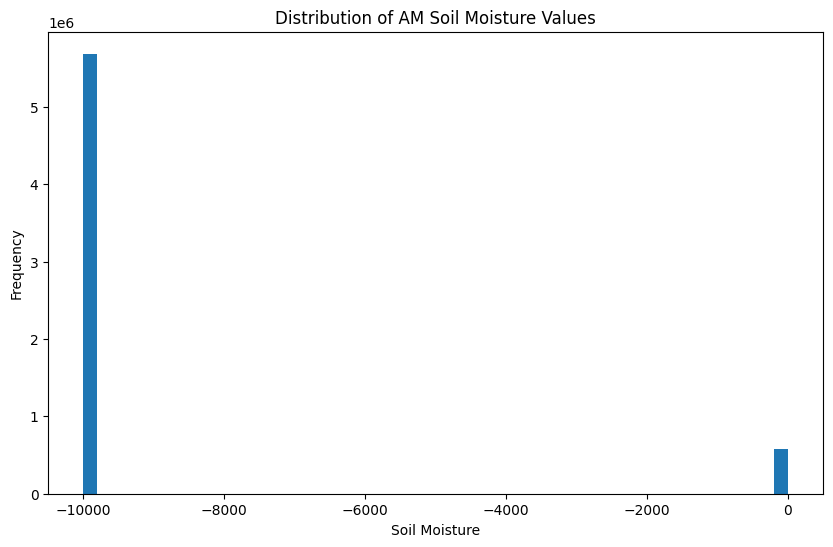

In [48]:
# Open the file again since it was closed in the previous cell
with h5py.File('../Data/SMAP_L3_SM_P_E_20250402_R19240_001.h5', 'r') as h5_file:
    # Access the soil moisture AM dataset
    soil_moisture_am = h5_file['/Soil_Moisture_Retrieval_Data_AM/soil_moisture'][:]
    # filter the Soil_Moisture_Retrieval_Data_AM/longitude_centroid and latitude_centroid to be within canada
    latitudes = h5_file['/Soil_Moisture_Retrieval_Data_AM/latitude_centroid'][:]
    longitudes = h5_file['/Soil_Moisture_Retrieval_Data_AM/longitude_centroid'][:]
    # # Create a mask for latitudes and longitudes within Canada
    # lat_mask = (latitudes >= 47) & (latitudes <= 63.23324)
    # lon_mask = (longitudes >= -141.000002) & (longitudes <= -52.648098)
    # # Combine masks to filter the soil moisture data
    # mask = lat_mask & lon_mask
    # # Apply the mask to the soil moisture data
    # soil_moisture_am = np.where(mask, soil_moisture_am, np.nan)
    # #drop nan values
    # soil_moisture_am = soil_moisture_am[~np.isnan(soil_moisture_am)]

    sm_df = pd.DataFrame()
    sm_df['Soil Moisture AM'] = soil_moisture_am.flatten()
    sm_df['Latitude'] = latitudes.flatten()
    sm_df['Longitude'] = longitudes.flatten()
    # sm_df['Latitude'] = latitudes[mask].flatten()
    # sm_df['Longitude'] = longitudes[mask].flatten()

    

    
        
    # Print basic information about the dataset
    print("Shape of soil moisture AM data:", soil_moisture_am.shape)
    print("\nBasic statistics:")
    print("Mean:", np.nanmean(soil_moisture_am))
    print("Min:", np.nanmin(soil_moisture_am))
    print("Max:", np.nanmax(soil_moisture_am))
    
    # Create a simple histogram of valid values
    valid_data = soil_moisture_am[~np.isnan(soil_moisture_am)]
    plt.figure(figsize=(10, 6))
    plt.hist(valid_data.flatten(), bins=50)
    plt.title('Distribution of AM Soil Moisture Values')
    plt.xlabel('Soil Moisture')
    plt.ylabel('Frequency')
    plt.show()

In [49]:
#make a map where the soil moisture is plotted
import geopandas as gpd
import folium
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # Import matplotlib.colors
#import linearcolormaps
from folium import LinearColormap

# Assume sm_df is your DataFrame loaded correctly
# Example placeholder if you don't have sm_df loaded:
# import pandas as pd
# data = {'Latitude': np.random.uniform(50, 60, 5000),
#         'Longitude': np.random.uniform(-120, -90, 5000),
#         'Soil Moisture AM': np.random.uniform(0, 0.6, 5000)}
# data['Soil Moisture AM'][np.random.choice(5000, 500, replace=False)] = -9999 # Add some invalid values
# sm_df = pd.DataFrame(data)


#make the dataframe a geodataframe
sm_df = gpd.GeoDataFrame(sm_df, geometry=gpd.points_from_xy(sm_df['Longitude'], sm_df['Latitude']))
sm_df.crs = "EPSG:4326"

#only take every 50th point to reduce the size of the dataframe
sm_df_reduced = sm_df.iloc[::10, :].copy() # Use .copy() to avoid SettingWithCopyWarning


m = folium.Map(location=[56, -106], zoom_start=4)

# Create a colormap
# Filter out -9999 values before finding min and max
valid_sm = sm_df_reduced['Soil Moisture AM'][sm_df_reduced['Soil Moisture AM'] != -9999]

# Check if there are any valid soil moisture values left after filtering
if not valid_sm.empty:
    min_sm = valid_sm.min()
    max_sm = valid_sm.max()
    print("Min Soil Moisture:", min_sm)
    print("Max Soil Moisture:", max_sm)
    mean_sm = valid_sm.mean()
    std_sm = valid_sm.std()
    print("Mean Soil Moisture:", mean_sm)
    print("Std Soil Moisture:", std_sm)

    # Ensure std_sm is not zero to avoid division by zero
    if std_sm == 0:
        print("Standard deviation is zero. Cannot normalize using z-score.")
        # Handle this case, maybe assign a default color or skip normalization
        std_sm = 1 # Assign 1 to avoid error, but normalization might not be meaningful

    # Get the colormap function
    cmap = plt.cm.get_cmap('YlGn')

    # Add points to the map
    for idx, row in sm_df_reduced.iterrows():
      if row['Soil Moisture AM'] != -9999:  # Skip invalid values
          # Normalize the value using mean and std (z-score)
          z_score = (row['Soil Moisture AM'] - mean_sm) / std_sm
          # Clip z-score to [-2, 2] range and normalize to [0, 1]
          normalized_value = np.clip((z_score + 2) / 4, 0, 1)

          # Get the RGBA color from the colormap
          rgba_color = cmap(normalized_value)
          # Convert RGBA to Hex format for Folium
          hex_color = mcolors.to_hex(rgba_color)

          folium.CircleMarker(
              location=[row['Latitude'], row['Longitude']],
              radius=3,
              color=hex_color,       # Use hex color string
              fill=True,
              fill_color=hex_color,  # Use hex color string
              fill_opacity=1,        # Changed opacity to 1 for solid color
              popup=f"Soil Moisture: {row['Soil Moisture AM']:.3f}"
          ).add_to(m)

# --- Add Colormap Legend AFTER the loop ---
    # Generate a list of colors from the cmap for the legend
    num_steps = 11 # How many color steps in the legend
    legend_colors = [mcolors.to_hex(cmap(i)) for i in np.linspace(0, 1, num_steps)]

    colormap = LinearColormap(
        colors=legend_colors, # Use the generated hex colors
        vmin=min_sm,          # Minimum value of your data range
        vmax=max_sm,          # Maximum value of your data range
        caption='Soil Moisture (m³/m³)' # Legend title
    )
    colormap.add_to(m) # Add the colormap legend to the map
    # --- End Legend ---



else:
    print("No valid soil moisture data points found in the reduced dataframe.")


# Display the map (in a Jupyter environment)
m
# Or save it to an HTML file:
m.save('../output/soil_moisture_map.html')

Min Soil Moisture: 0.02
Max Soil Moisture: 0.7467416
Mean Soil Moisture: 0.19018431
Std Soil Moisture: 0.15180571


/tmp/ipykernel_7110/2356549281.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlGn')
